# Rolling Forecast

## Introduction

### Objectives

We want to predict the next rolling 6-month revenue for each hotel based on booking transactions history.

The solution should be able to be run at any time of the year and provide a prediction.

The results should include:
- Explanation of the approach used
- Model accuracy
- Confidence interval


### Approach

### Main steps

### Conclusions

## Data field	Definition

1. `hotel` — Hotel (H1 = Resort Hotel or H2 = City Hotel)
1. `is_canceled` — Value indicating if the booking was canceled (1) or not (0)
1. `lead_time` — Number of days that elapsed between the entering date of the booking into the PMS and the arrival date
1. `arrival_date_year` — Year of arrival date
1. `arrival_date_month` — Month of arrival date
1. `arrival_date_week_number` — Week number of year for arrival date
1. `arrival_date_day_of_month` — Day of arrival date
1. `stays_in_weekend_nights` — Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
1. `stays_in_week_nights` — Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
1. `adults` — Number of adults
1. `children` — Number of children
1. `babies` — Number of babies
1. `meal` — Type of meal booked. Categories are presented in standard hospitality meal packages: 
    - Undefined/SC – no meal package; 
    - BB – Bed & Breakfast; 
    - HB – Half board (breakfast and one other meal – usually dinner); 
    - FB – Full board (breakfast, lunch and dinner)
1. `country` — Country of origin. Categories are represented in the ISO 3155–3:2013 format
1. `market_segment` — Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”
1. `distribution_channel` — Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”
1. `is_repeated_guest` — Value indicating if the booking name was from a repeated guest (1) or not (0)
1. `previous_cancellations` — Number of previous bookings that were cancelled by the customer prior to the current booking
1. `previous_bookings_not_canceled` — Number of previous bookings not cancelled by the customer prior to the current booking
1. `reserved_room_type` — Code of room type reserved. Code is presented instead of designation for anonymity reasons.
1. `assigned_room_type` — Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons.
1. `booking_changes` — Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation
1. `deposit_type` — Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: 
    - No Deposit – no deposit was made; 
    - Non Refund – a deposit was made in the value of the total stay cost; 
    - Refundable – a deposit was made with a value under the total cost of stay.
1. `agent` — ID of the travel agency that made the booking
1. `company` — ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons
1. `days_in_waiting_list` — Number of days the booking was in the waiting list before it was confirmed to the customer
1. `customer_type` — Type of booking, assuming one of four categories: 
    - Contract - when the booking has an allotment or other type of contract associated to it; 
    - Group – when the booking is associated to a group; 
    - Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; 
    - Transient-party – when the booking is transient, but is associated to at least other transient booking
1. `adr` — Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights
1. `required_car_parking_spaces` — Number of car parking spaces required by the customer
1. `total_of_special_requests` — Number of special requests made by the customer (e.g. twin bed or high floor)
1. `reservation_status` — Reservation last status, assuming one of three categories: 
    - Canceled – booking was canceled by the customer; 
    - Check-Out – customer has checked in but already departed; 
    - No-Show – customer did not check-in and did inform the hotel of the reason why
1. `reservation_status_date` — Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus

## Terminology

### Rolling Forecast

A rolling forecast is a type of financial model that predicts the future performance of a business over a continuous period, based on historical data. Unlike static budgets that forecast the future for a fixed time frame, e.g., January to December, a rolling forecast is regularly updated throughout the year to reflect any changes.

Source [CFI](https://corporatefinanceinstitute.com/resources/accounting/rolling-forecast/)

![Rolling Forecast](https://docs.oracle.com/cd/E57185_01/AGOHP/images/graphics/rolling_forecast_12_month.gif)

Source [Oracle](https://docs.oracle.com/cd/E57185_01/AGOHP/ch06s04s06s01.html)


### Average Daily Rate

In data field definition Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights

$$
\text{ADR} = \frac{\sum_{i=1}^{n}\text{Lodging Transaction}_i}{\text{Number of Staying Nights}}
$$

Note this difinition differs from industry perfomance indicatior ADR that tells a lodging company how much they make per room on average in a given day. Here Average Daily Rate as defined by dividing  the total rooms revenue at your hotel by the total occupied rooms. 

$$
\text{ADR} = \frac{\text{Rooms Revenue Earned}}{\text{Number of Rooms Sold}}
$$

"A" in ADR stands for "average" because you'll usually be looking at YTD (year to date) or TTM (trailing twelve months) averages

Source: [Investopedia](https://www.investopedia.com/terms/a/average-daily-rate.asp)



### Revenue Allocation


According to [Accounting Standard Codification (ASC) 606](https://revgurus.com/knowledge-center-asc-606-hotel-industry/) Hotel amortizes revenue from room rentals and allied servives equally over period of stay of the customer, i.e. on each day till he/she check-out. 

Thus Revenue is allocated to the month or months which have period of customer stay. Let's assume the cancelation deposit is allocated in a month of last reservation status was set.

### Conclusions

The definition of ADR in the dataset is different from the ADR industry performance measure. The latter is determined by dividing your hotel's total room revenue by the total number of occupied rooms. This understanding helps us answer why the adr values are different for bookings on the same day at the same hotel.

Based on the definition of ADR in the dataset, we assume that booking revenue is the product of ADR and total nights of stay. In case of cancellation, the revenue generated by a booking works the same way as a product of ADR and total nights if they were a deposit or not and if it is refundable or not. 

$$
\begin{equation}
    \text{Booking revenue} = 
    \begin{cases}
        \text{checked-out } \text{OR } \text {canceled with non-refundable deposit} & 
            \text{ARD } \times \text{ Number of nights } \\
        \text{otherwise } & 
            0
    \end{cases}
\end{equation}
$$

In accordance with the codification of Accounting Standard 606, the Hotel amortizes revenue from room rentals and allied servives equally during the period of the client's stay, i.e. for each day before his or her departure or for each night staying. In case of cancellation, there are no actual staying so we recognize the entire amount of the refundable deposit on the day the status changes to Cancelled.


$$
\begin{equation}
    \text{Booking Revenue}_{month} = 
    \begin{cases}
        \text{checked-out }  & 
            \text{ARD } \times \text{ Number of nights }_{month}, \text{night} \in \text{month} \\
        \text{canceled with non-refundable deposit }  & 
            \text{ARD } \times \text{ Number of nights }, \text{cancellation_date} \in \text{month} \\
        \text{otherwise } & 
            0
    \end{cases}
\end{equation}
$$


 

## Approach

Recursive multi-step forecasting Direct multi-step forecasting
https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

Explore
- adr
- total nights staying

For each hotel calculate monthly revenue allocating check-out'ed booking to the corresponding days of staying and cancelled to the date of status set.

## Code setup

This section contains programming code to load libraries and define functions that will be used in the work.

### Load packages

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

### Constant definitions

### Function definitions

In [4]:
def build_datetime(year: int, month: str, day: int) -> pd.Timestamp:
    '''Transforms part of the date into pandas.Timestamp
    '''
    return pd.to_datetime(
        str(year) + '-' + month + '-' + str(day),
        format='%Y-%B-%d'
    )

In [5]:
def draw_hist_and_boxplot(data, column, title, vline=None):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(5, 6), sharex=True)
    data[column].hist(bins=60, ax=ax1)
    data.boxplot(ax=ax2, column=column, vert=False)
    ax2.set_xlabel(column)
    if vline:
        ax1.axvline(vline, color='red')
    ax1.title.set_text(title)
    plt.show()

In [6]:
def draw_num_transactions(data, index, column, title):
    pd.pivot_table(data,
                   index=index,
                   columns=column,
                   values='hotel',
                   aggfunc='count').resample('M').sum().plot(
                       figsize=(10, 4),
                       marker='o',
                       markersize=9,
                       lw=3,
                       color=['C1', 'C2', 'C3'])
    plt.ylabel('Number of transactions')
    plt.title(title.upper())
    plt.tight_layout()
    plt.grid(True)
    plt.show()    

In [7]:
def calculate_daily_revenue_stream(data, n_days, start_date) -> np.ndarray:
    
    revenue_stream = np.zeros(n_days)
    
    for i, row in data.iterrows():

        # check if a booking is canceled
        if row.is_canceled == 1 and row.deposit_type == 'Non Refund':
            # recognize all revenue to the reservation_status_date
            idx = (row.reservation_status_date - start_date).days
            if 0 <= idx < n_days:
                revenue = row.adr * row.total_nights
                # add total revenue to the correspondent day's revenue
                revenue_stream[idx] += revenue
                
        elif row.is_canceled == 0:
            # recognize revenue evenly for the whole period of stay

            # calculate index as number of days since start_date
            idx = (row.arrival_date - start_date).days
            for step in range(row.total_nights):
                if idx+step > n_days-1:
                    # the staying goes after end of anylised period
                    break
                # add adr as revenue per day to the correspondent day's revenue
                revenue_stream[idx+step] += row.adr
                
    return revenue_stream

In [56]:
def plotMovingAverage(
    series, window, plot_intervals=False, scale=1.96, plot_anomalies=False, ylabel=""
):

    """
        Plots moveing average chart
        
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", lw=2, label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", alpha=.25, label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--", alpha=.25)

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=5)

    plt.plot(series[window-1:], alpha=.75, lw=.5, label="Actual values")
    plt.legend(loc="upper left")
    plt.ylabel(ylabel)
    plt.grid(True)

## Load data

In [9]:
data = pd.read_excel('data/hotel_bookings.xlsx', sheet_name=0)
data.shape

(119390, 32)

Loaded dataset contains 119K observations and 32 features.

## Data quality analysis

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_year               119390 non-null  int64         
 4   arrival_date_month              119390 non-null  object        
 5   arrival_date_week_number        119390 non-null  int64         
 6   arrival_date_day_of_month       119390 non-null  int64         
 7   stays_in_weekend_nights         119390 non-null  int64         
 8   stays_in_week_nights            119390 non-null  int64         
 9   adults                          119390 non-null  int64         
 10  children                        119386 non-null  float64

Dataset has the fields coresponding to data definition.

Date of bookings are represented by separate datetime fields. 

Nights of staying are divided by week and weeknd parts. 



### Duplicates

At first let's check if the dataset has duplicated rows.

In [11]:
data.duplicated().sum()

31994

Dataset has duplicated rows. We consider to have two bookings with identical parameters placed at the same day as unlikely and delete the duplicates.

In [12]:
data = data.drop_duplicates()
data.shape

(87396, 32)

### Narrow down columns

Let's transform arrival date to date-time format.

In [13]:
data['arrival_date'] = data.apply(
    lambda raw: build_datetime(raw.arrival_date_year, raw.arrival_date_month,
                               raw.arrival_date_day_of_month), axis=1)

In [14]:
data['total_nights'] = data.stays_in_weekend_nights + data.stays_in_week_nights

Let's focus on columns related to revenue in direct way.

In [15]:
df = data[[
    'arrival_date', 'reservation_status_date', 'hotel', 'adr', 'total_nights',
    'is_canceled', 'deposit_type', 'reservation_status'
]]

### General Overview

In [16]:
df.head()

,arrival_date,reservation_status_date,hotel,adr,total_nights,is_canceled,deposit_type,reservation_status
0,2015-07-01,2015-07-01,Resort Hotel,0.0,0,0,No Deposit,Check-Out
1,2015-07-01,2015-07-01,Resort Hotel,0.0,0,0,No Deposit,Check-Out
2,2015-07-01,2015-07-02,Resort Hotel,75.0,1,0,No Deposit,Check-Out
3,2015-07-01,2015-07-02,Resort Hotel,75.0,1,0,No Deposit,Check-Out
4,2015-07-01,2015-07-03,Resort Hotel,98.0,2,0,No Deposit,Check-Out


In [17]:
df.describe()

,adr,total_nights,is_canceled
count,87396.000000,87396.000000,87396.000000
mean,106.337246,3.630658,0.274898
std,55.013953,2.763449,0.446466
min,-6.380000,0.000000,0.000000
25%,72.000000,2.000000,0.000000
50%,98.100000,3.000000,0.000000
75%,134.000000,5.000000,1.000000
max,5400.000000,69.000000,1.000000


ADR varies from -6.4 to 5400. At the same time, for half of the observations, the ADR range is from 69 to 126.

Total_nights have maximim value 69 and 75 percentile is just 4. 

37% of bookings in dataset are cancelled. 

In [18]:
df.hotel.value_counts()

City Hotel      53428
Resort Hotel    33968
Name: hotel, dtype: int64

In [19]:
df.deposit_type.value_counts()

No Deposit    86251
Non Refund     1038
Refundable      107
Name: deposit_type, dtype: int64

### ADR

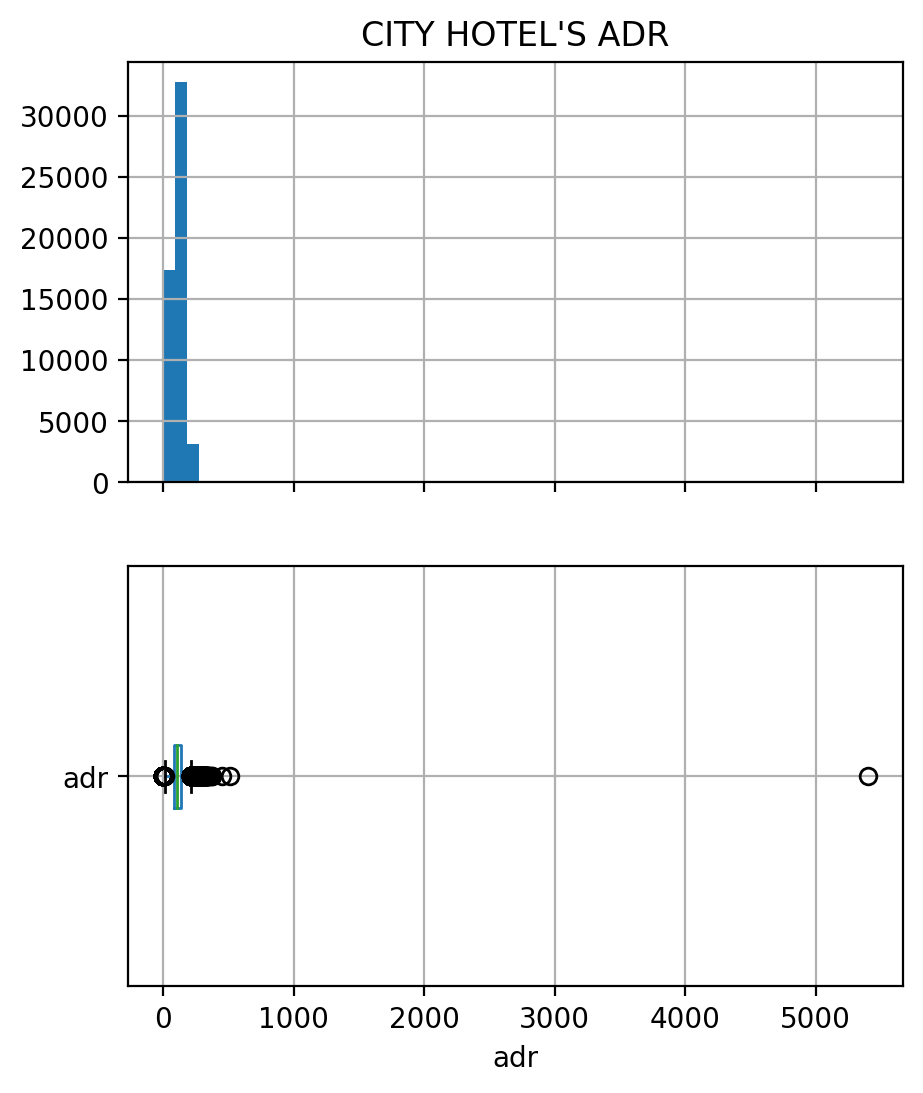

In [20]:
draw_hist_and_boxplot(data=df[df.hotel == 'City Hotel'],
                      column='adr',
                      title='City Hotel\'s ADR'.upper())

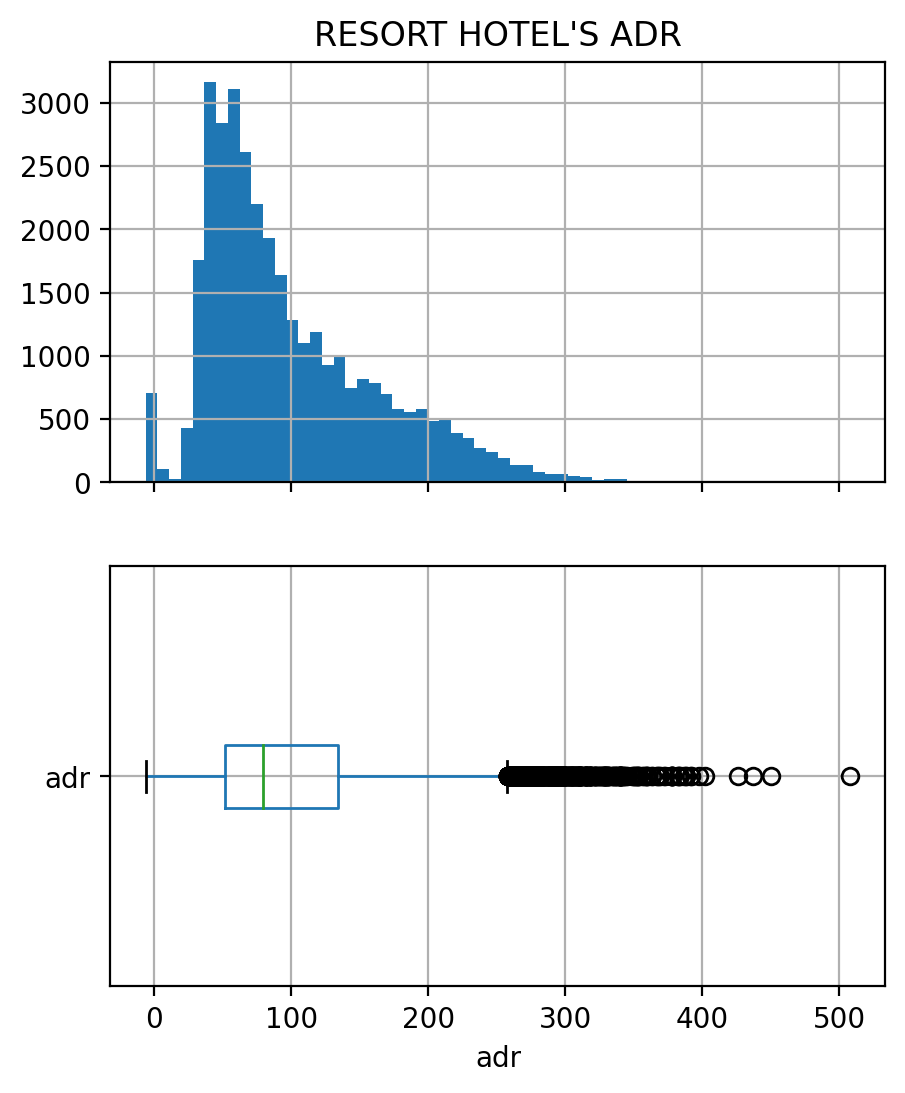

In [21]:
draw_hist_and_boxplot(data=df[df.hotel == 'Resort Hotel'],
                      column='adr',
                      title='Resort Hotel\'s ADR'.upper())

ADR greater than 5000 is an error. Delete this row.

In [22]:
df = df[df.adr < 1000]
df.shape

(87395, 8)

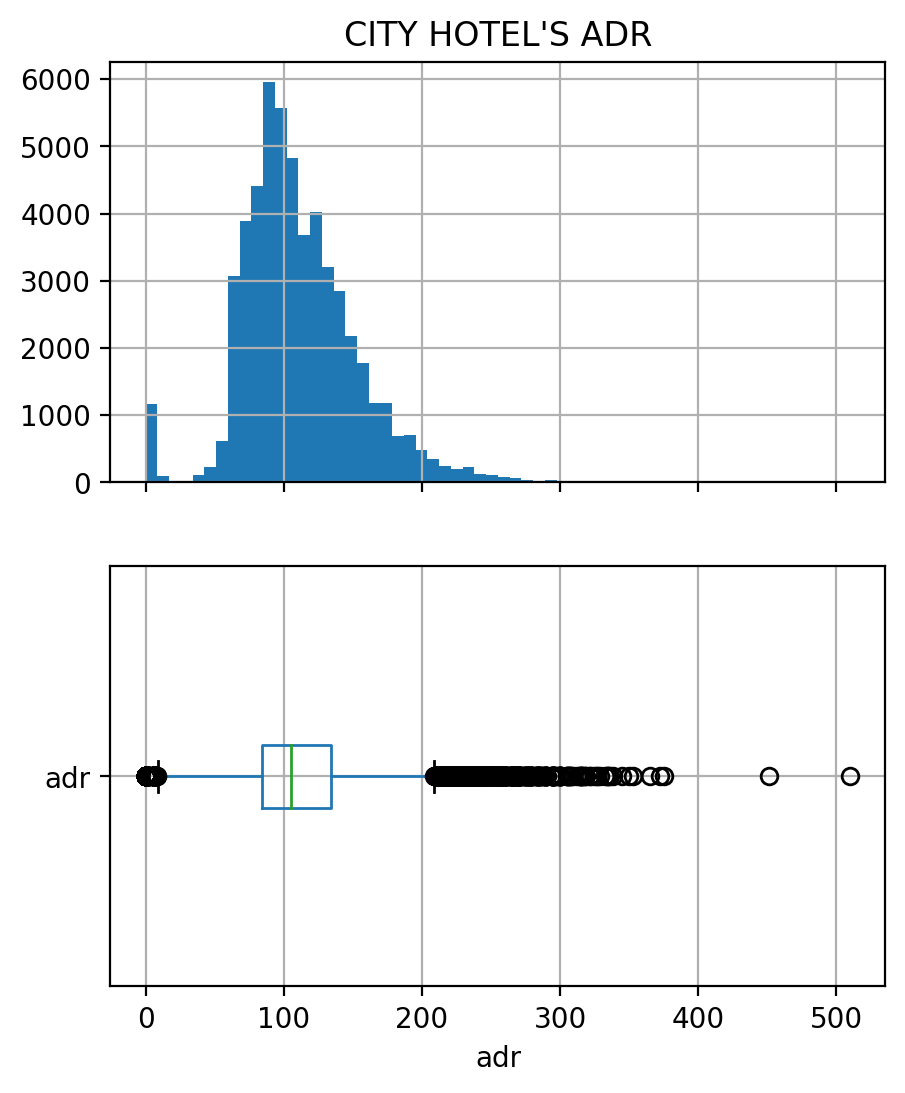

In [23]:
draw_hist_and_boxplot(data=df[df.hotel == 'City Hotel'],
                      column='adr',
                      title='City Hotel\'s ADR'.upper())

We left only rows with positive ADR

In [24]:
df = df[df.adr > 0]
df.shape

(85616, 8)

### Total nights

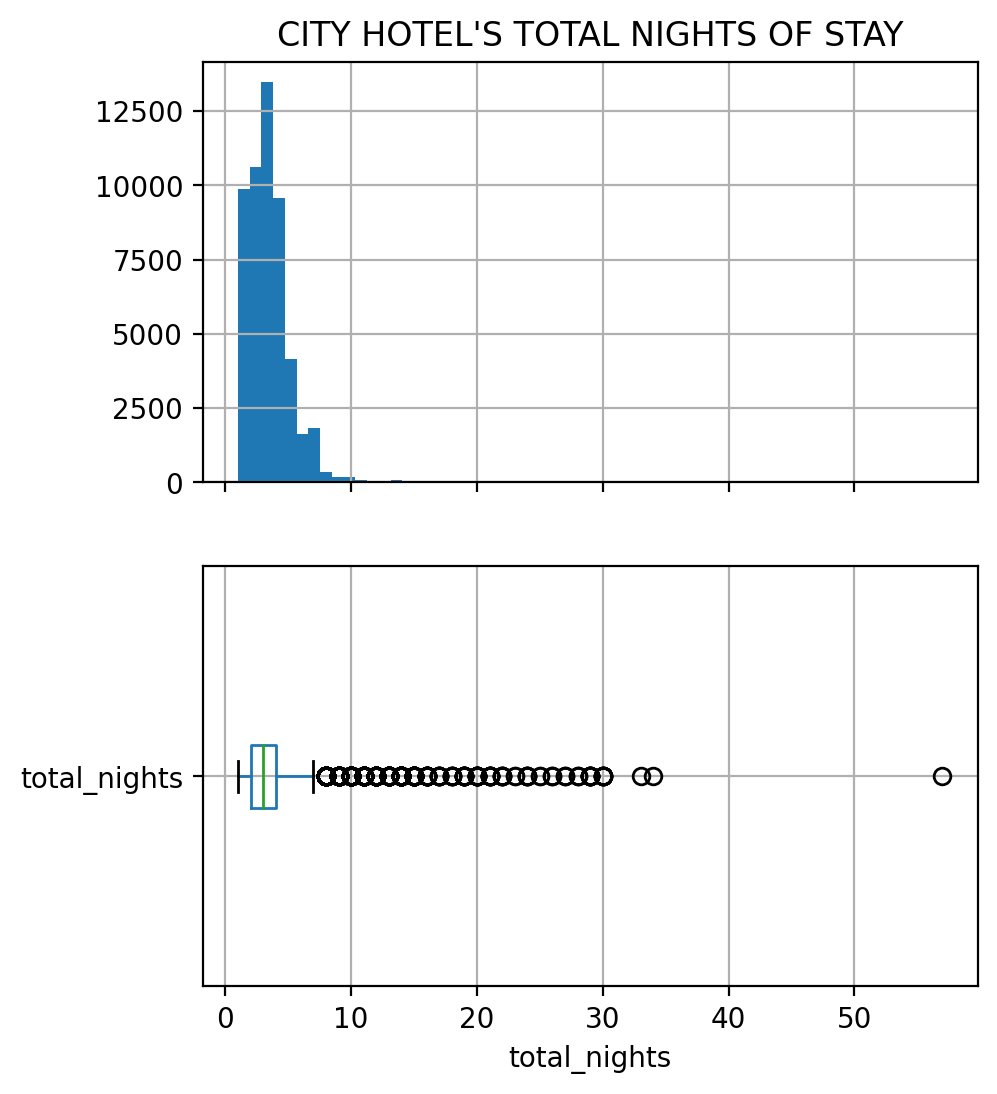

In [25]:
draw_hist_and_boxplot(data=df[df.hotel == 'City Hotel'],
                      column='total_nights',
                      title='City Hotel\'s total nights of stay'.upper())

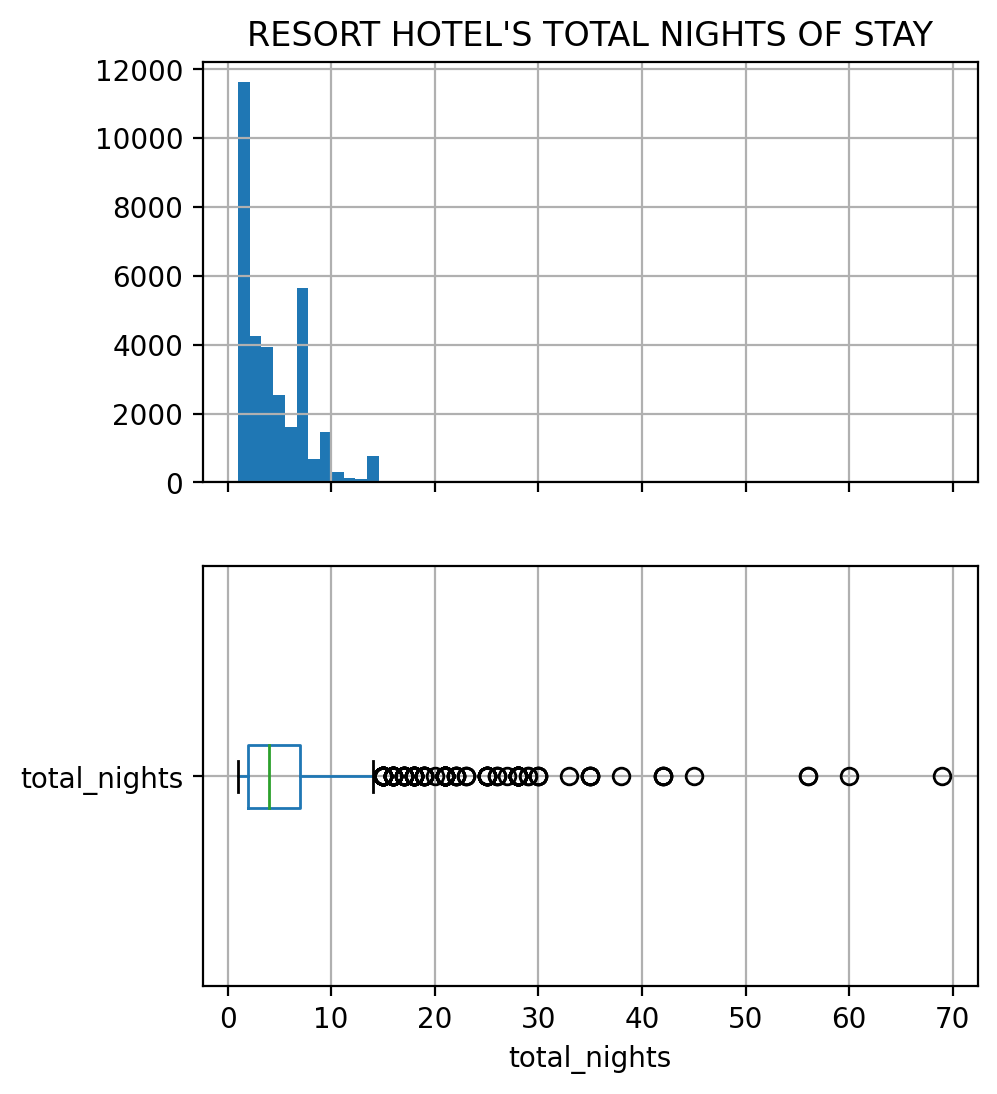

In [26]:
draw_hist_and_boxplot(data=df[df.hotel == 'Resort Hotel'],
                      column='total_nights',
                      title='Resort Hotel\'s total nights of stay'.upper())

We can imageine some rare guest stays for a couple of month. These data have no errors.

### Number of transactions

Revenue is a function of ADR and Status

What is dynamics of transaction over reservation_status_date

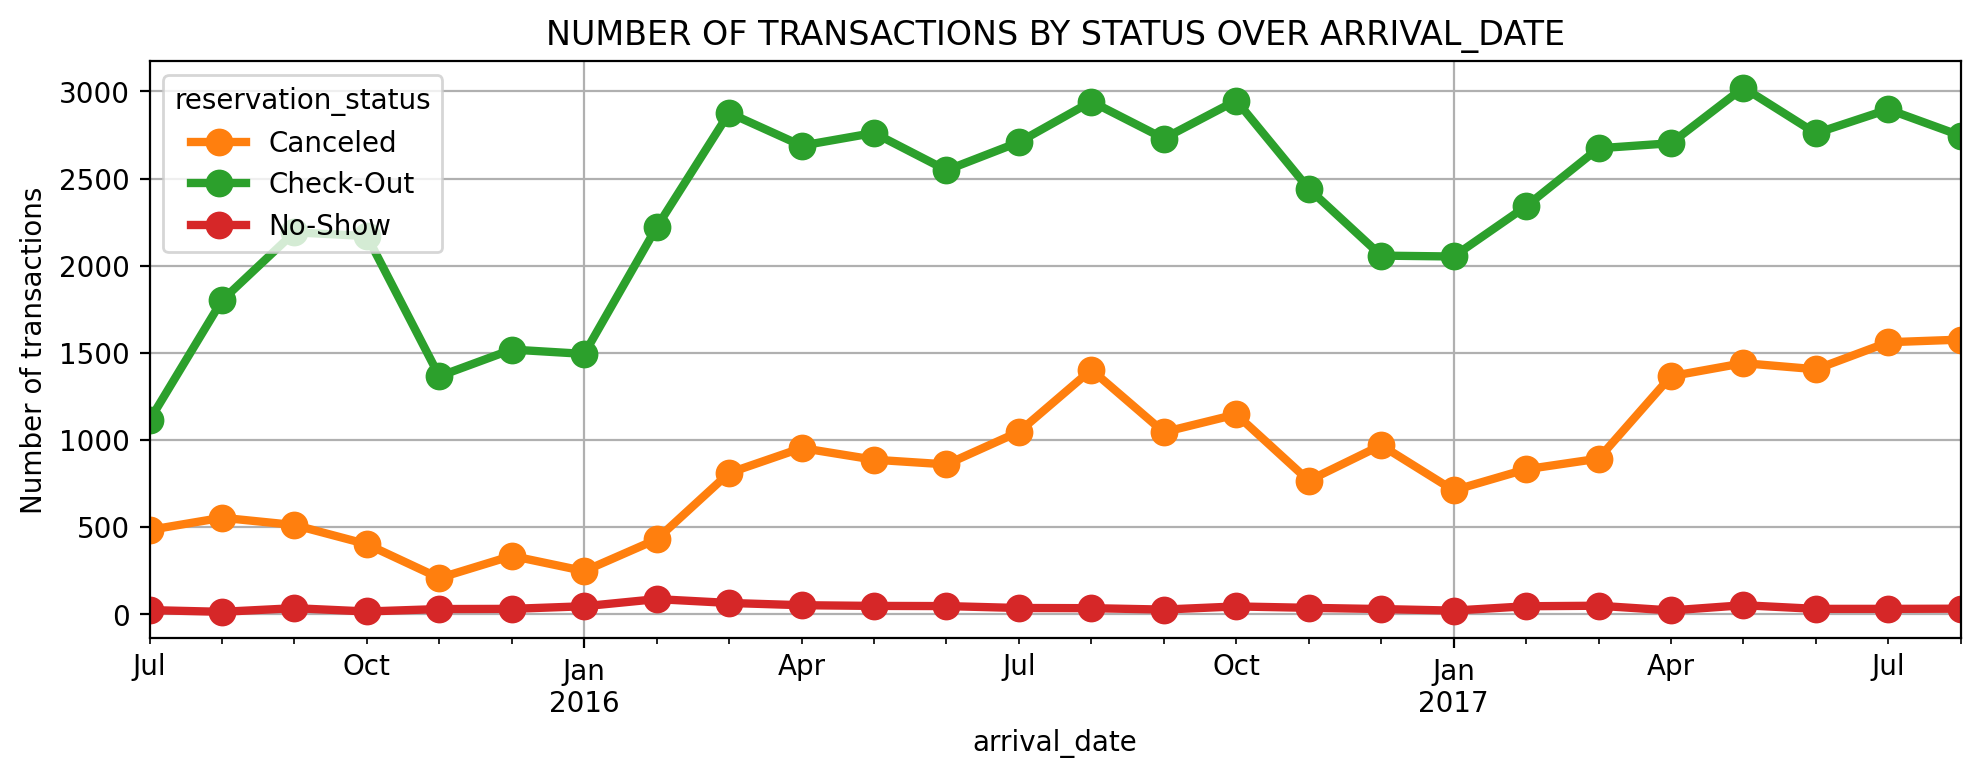

In [27]:
draw_num_transactions(data=df,
                      index='arrival_date',
                      column='reservation_status',
                      title='Number of transactions by status over arrival_date')

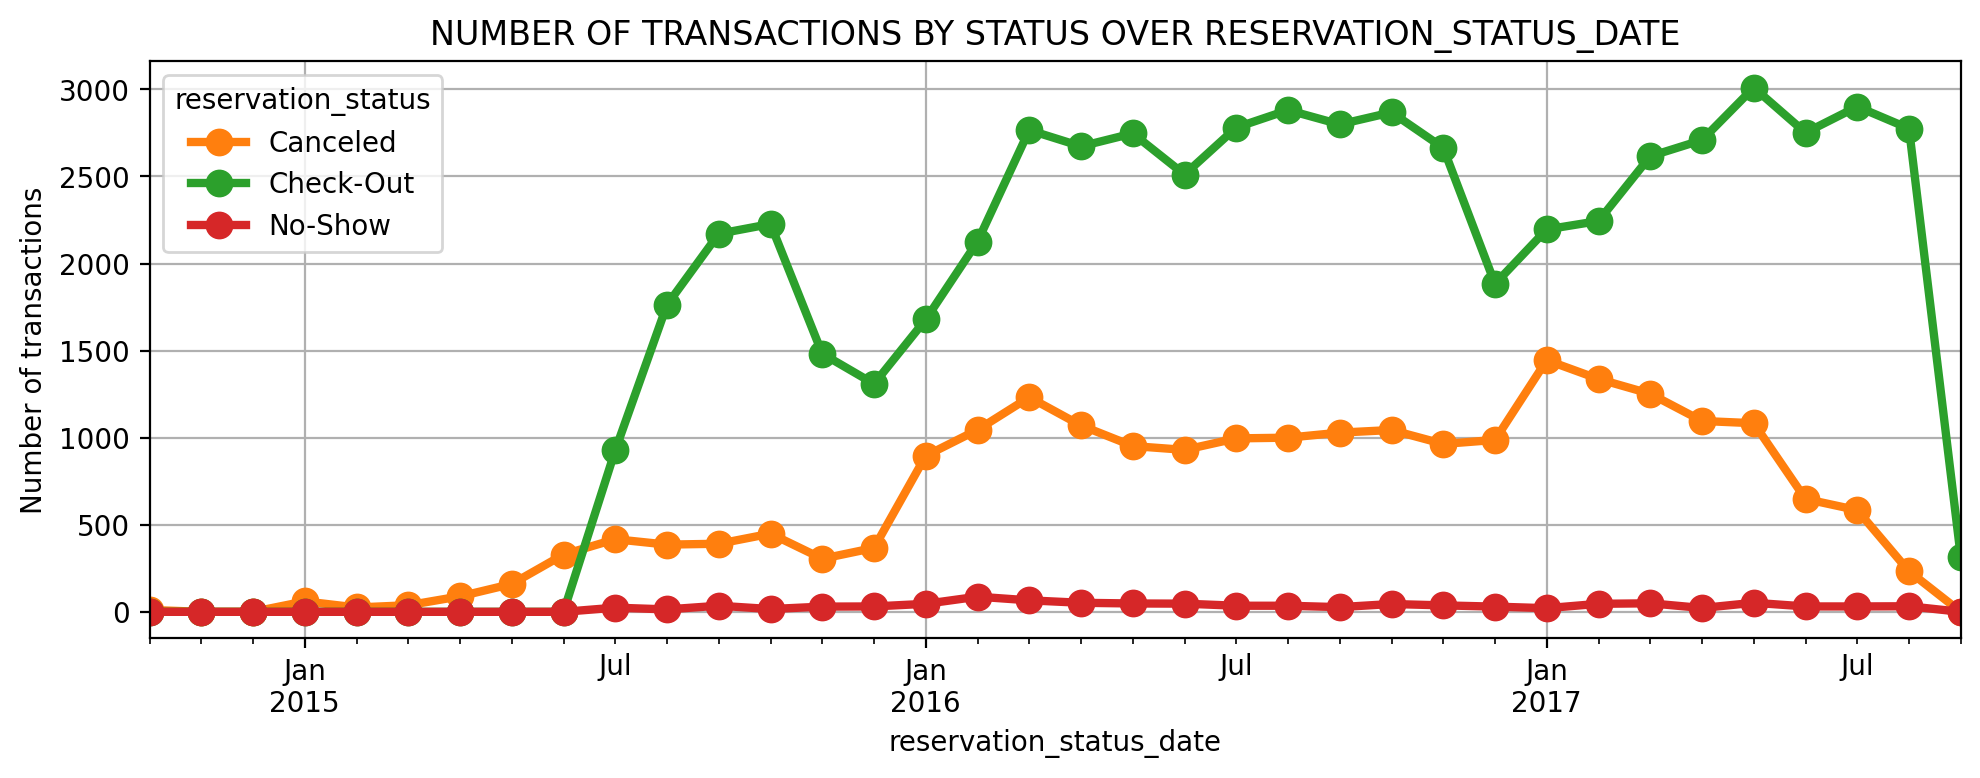

In [28]:
draw_num_transactions(data=df,
                      index='reservation_status_date',
                      column='reservation_status',
                      title='Number of transactions by status over reservation_status_date')

No show status is rare. Dataset has no transactions with Check-Out status until July 2015. Note the fast drop of Check-Out status at the last period. Thus we can define analysis term as from July 2015 to Aug 2017 included. It is 26 months. 

Which `reservation_status` values we can obseerve for `is_canceled` values?

In [29]:
pd.pivot_table(data, index='reservation_status', columns='is_canceled', values='hotel', aggfunc='count')

is_canceled,0,1
reservation_status,,
Canceled,NaN,23011.0
Check-Out,63371.0,NaN
No-Show,NaN,1014.0


In [30]:
for h in ['City Hotel', 'Resort Hotel']:
    print(f"{h} arrivals\tfrom {df.arrival_date.min().date()} to {df.arrival_date.max().date()}")

City Hotel arrivals	from 2015-07-01 to 2017-08-31
Resort Hotel arrivals	from 2015-07-01 to 2017-08-31


Not cancelled booking has Check-Out reservation status as it was expected.

## Revenue Calculation

We define `start_date` and `number_of_days` as a starting point of time series and its length.

In [31]:
start_date = df.arrival_date.min()
number_of_days = (df.arrival_date.max() - start_date).days + 1
start_date.date(), number_of_days

(datetime.date(2015, 7, 1), 793)

### Test function

We compare revenue calculated by `calculate_daily_revenue_stream` function with manually calculated revenue to be sure the function works correctly. 

For this we need dataset containing booking that generates revenue only.

In [32]:
pure_df = (
    df[
        df.reservation_status_date.between('2015-07-01', '2017-08-31')
        & (((df.is_canceled == 1) & df.deposit_type == 'Non Refund')
        | (df.is_canceled == 0))
    ]
)

In [33]:
print(f"Total revenue: {(pure_df.adr * pure_df.total_nights).sum():.2f}")

Total revenue: 22709375.14


In [34]:
revenue_stream = calculate_daily_revenue_stream(data=pure_df,
                                                n_days=number_of_days,
                                                start_date=start_date)

In [35]:
print(f"Total revenue: {revenue_stream.sum():.2f}")

Total revenue: 22709375.14


In [36]:
np.isclose(revenue_stream.sum(), (pure_df.adr * pure_df.total_nights).sum())

True

### Revenue stream for each hotel

In [37]:
revenue_stream = dict()
for hotel in ['City Hotel', 'Resort Hotel']:
    revenue_stream[hotel] = calculate_daily_revenue_stream(
        data=df[df.hotel == hotel],
        n_days=number_of_days,
        start_date=start_date)

In [38]:
revenue_stream = pd.DataFrame(revenue_stream,
                              index=pd.date_range(start=start_date,
                                                  periods=number_of_days))

In [39]:
revenue_stream.head()

,City Hotel,Resort Hotel
2015-07-01,471.00,3174.16
2015-07-02,5013.67,5931.66
2015-07-03,1121.94,7830.68
2015-07-04,827.94,10251.80
2015-07-05,514.27,11680.05


In [40]:
revenue_stream = revenue_stream.resample('1M').sum()
revenue_stream.head()

,City Hotel,Resort Hotel
2015-07-31,36805.79,593209.82
2015-08-31,210799.59,825376.23
2015-09-30,445672.77,452945.92
2015-10-31,364644.97,260228.17
2015-11-30,150751.10,132981.15


City hotel has anomally low revenue at July 2015.

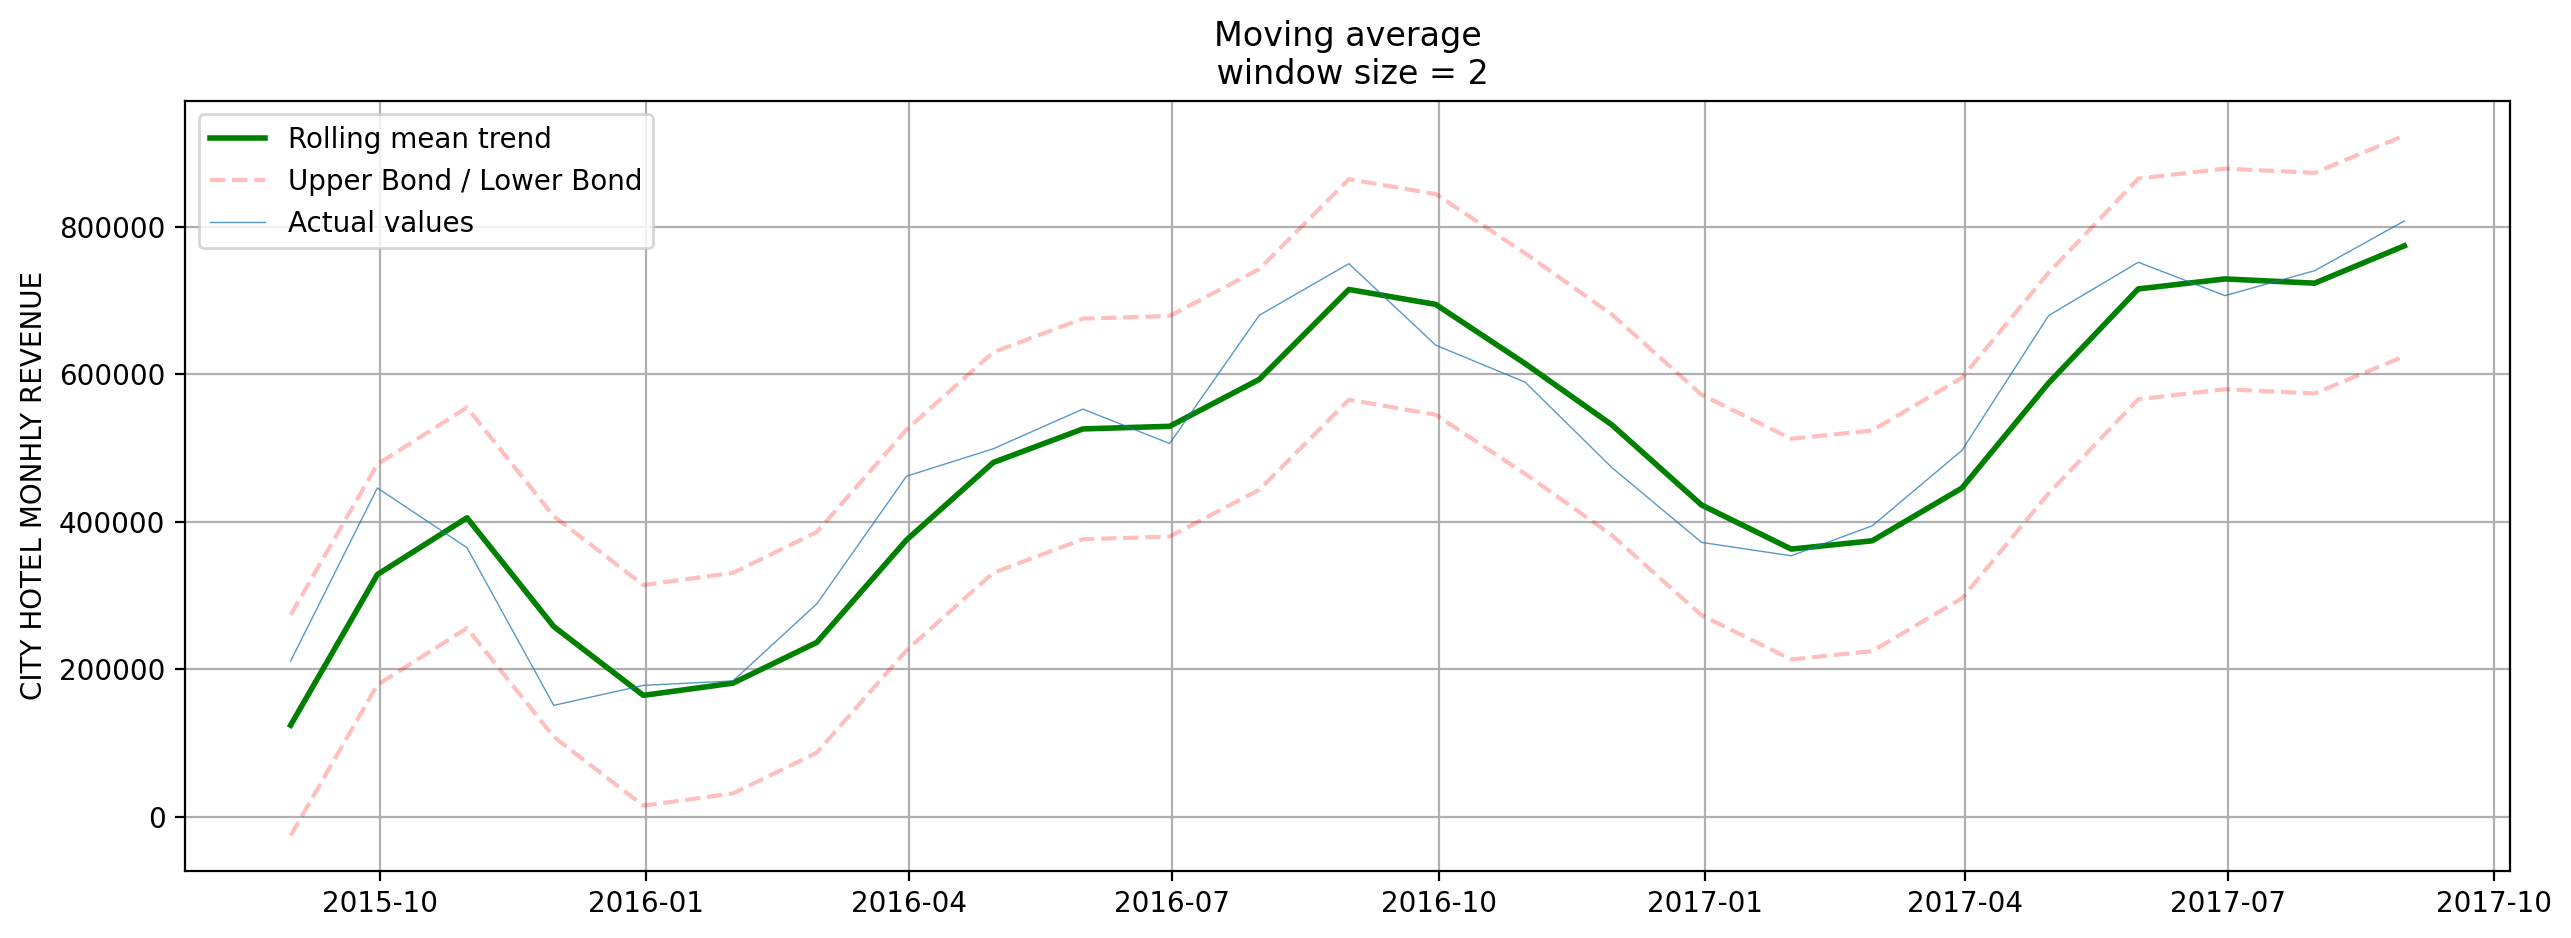

In [62]:
plotMovingAverage(revenue_stream.drop('Resort Hotel', axis=1),
                  2,
                  plot_intervals=True,
                  plot_anomalies=True,
                  ylabel="City Hotel Monhly Revenue".upper())

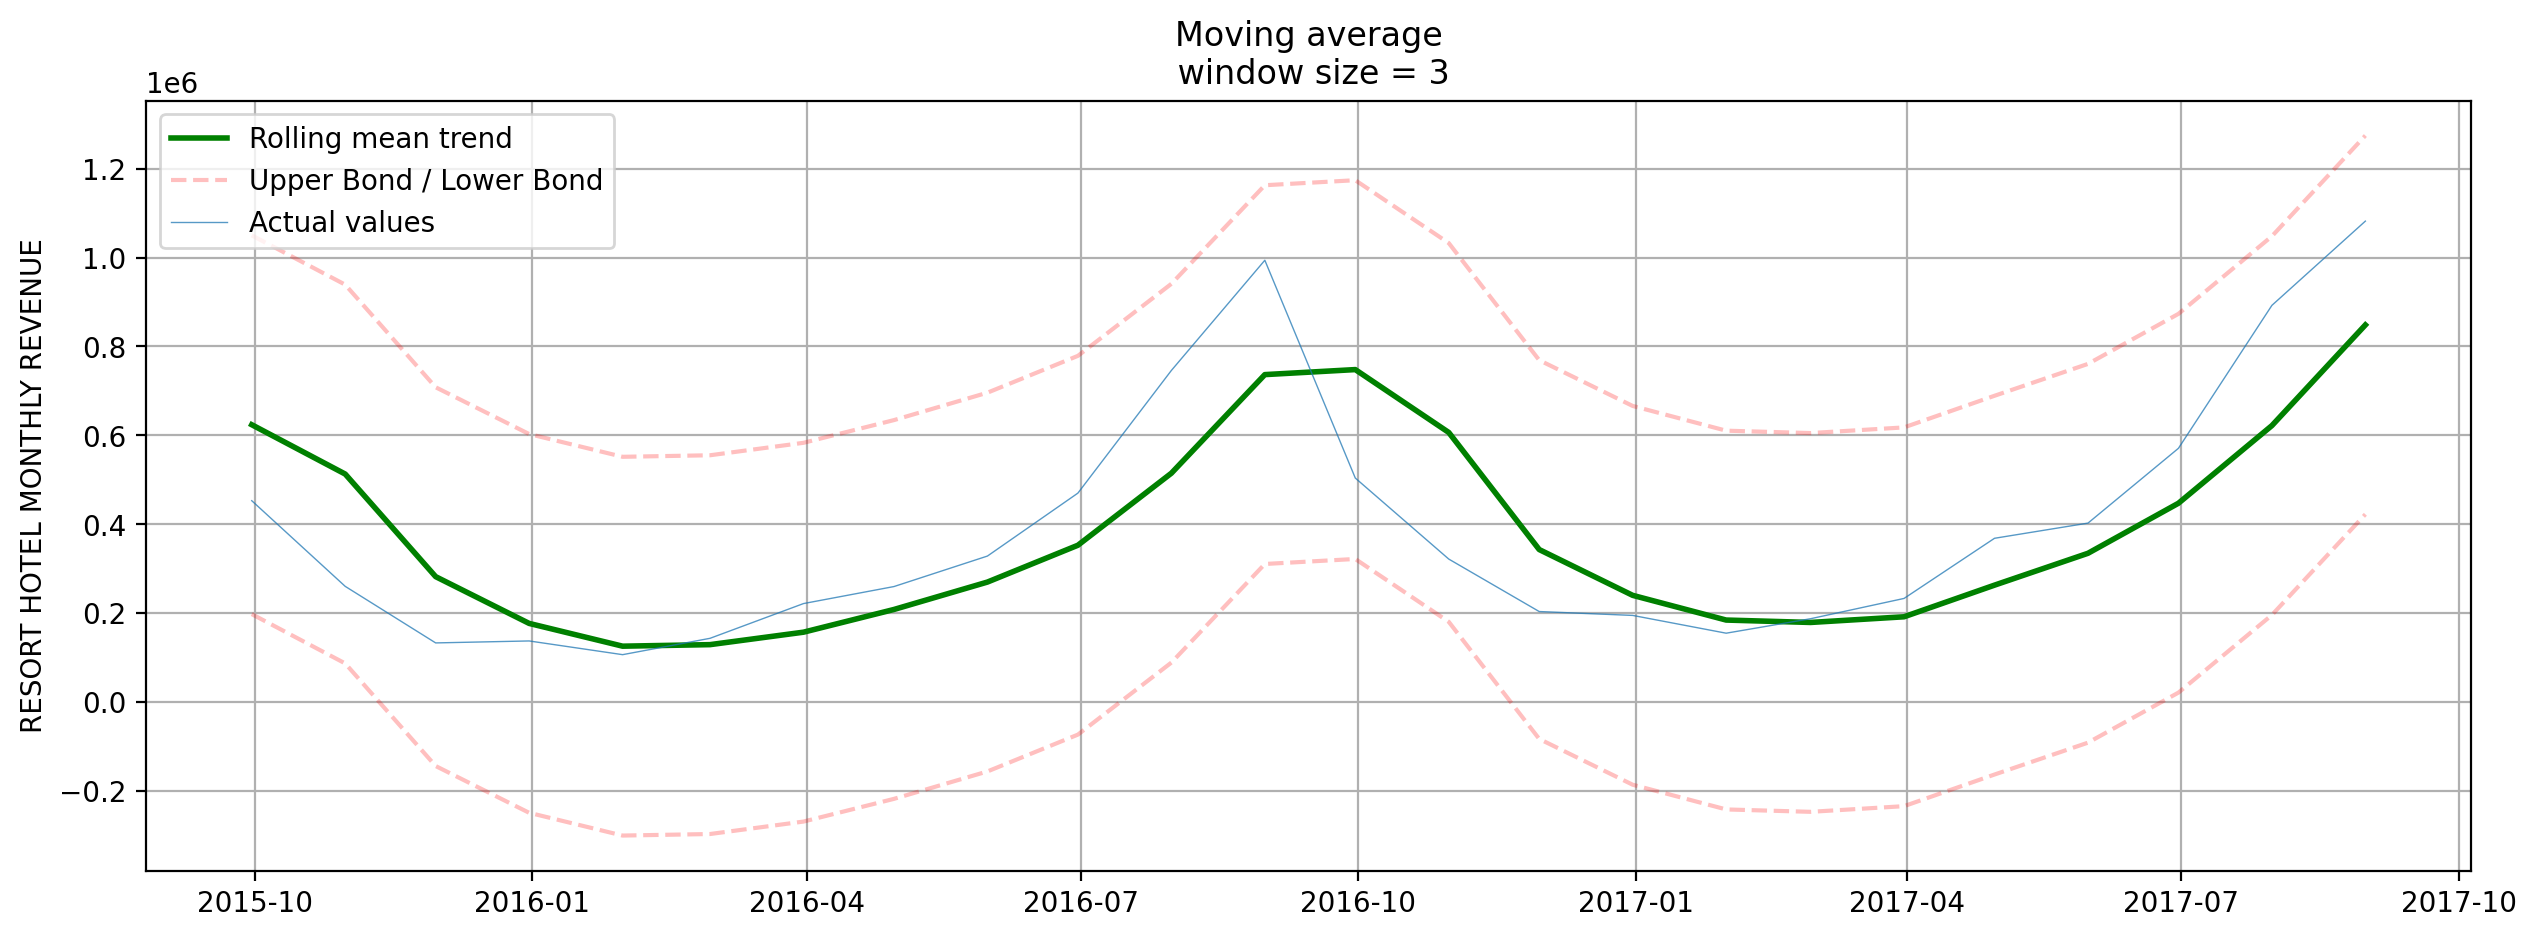

In [63]:
plotMovingAverage(revenue_stream.drop('City Hotel', axis=1),
                  3,
                  plot_intervals=True,
                  plot_anomalies=True,
                  ylabel="Resort Hotel Monthly Revenue".upper())

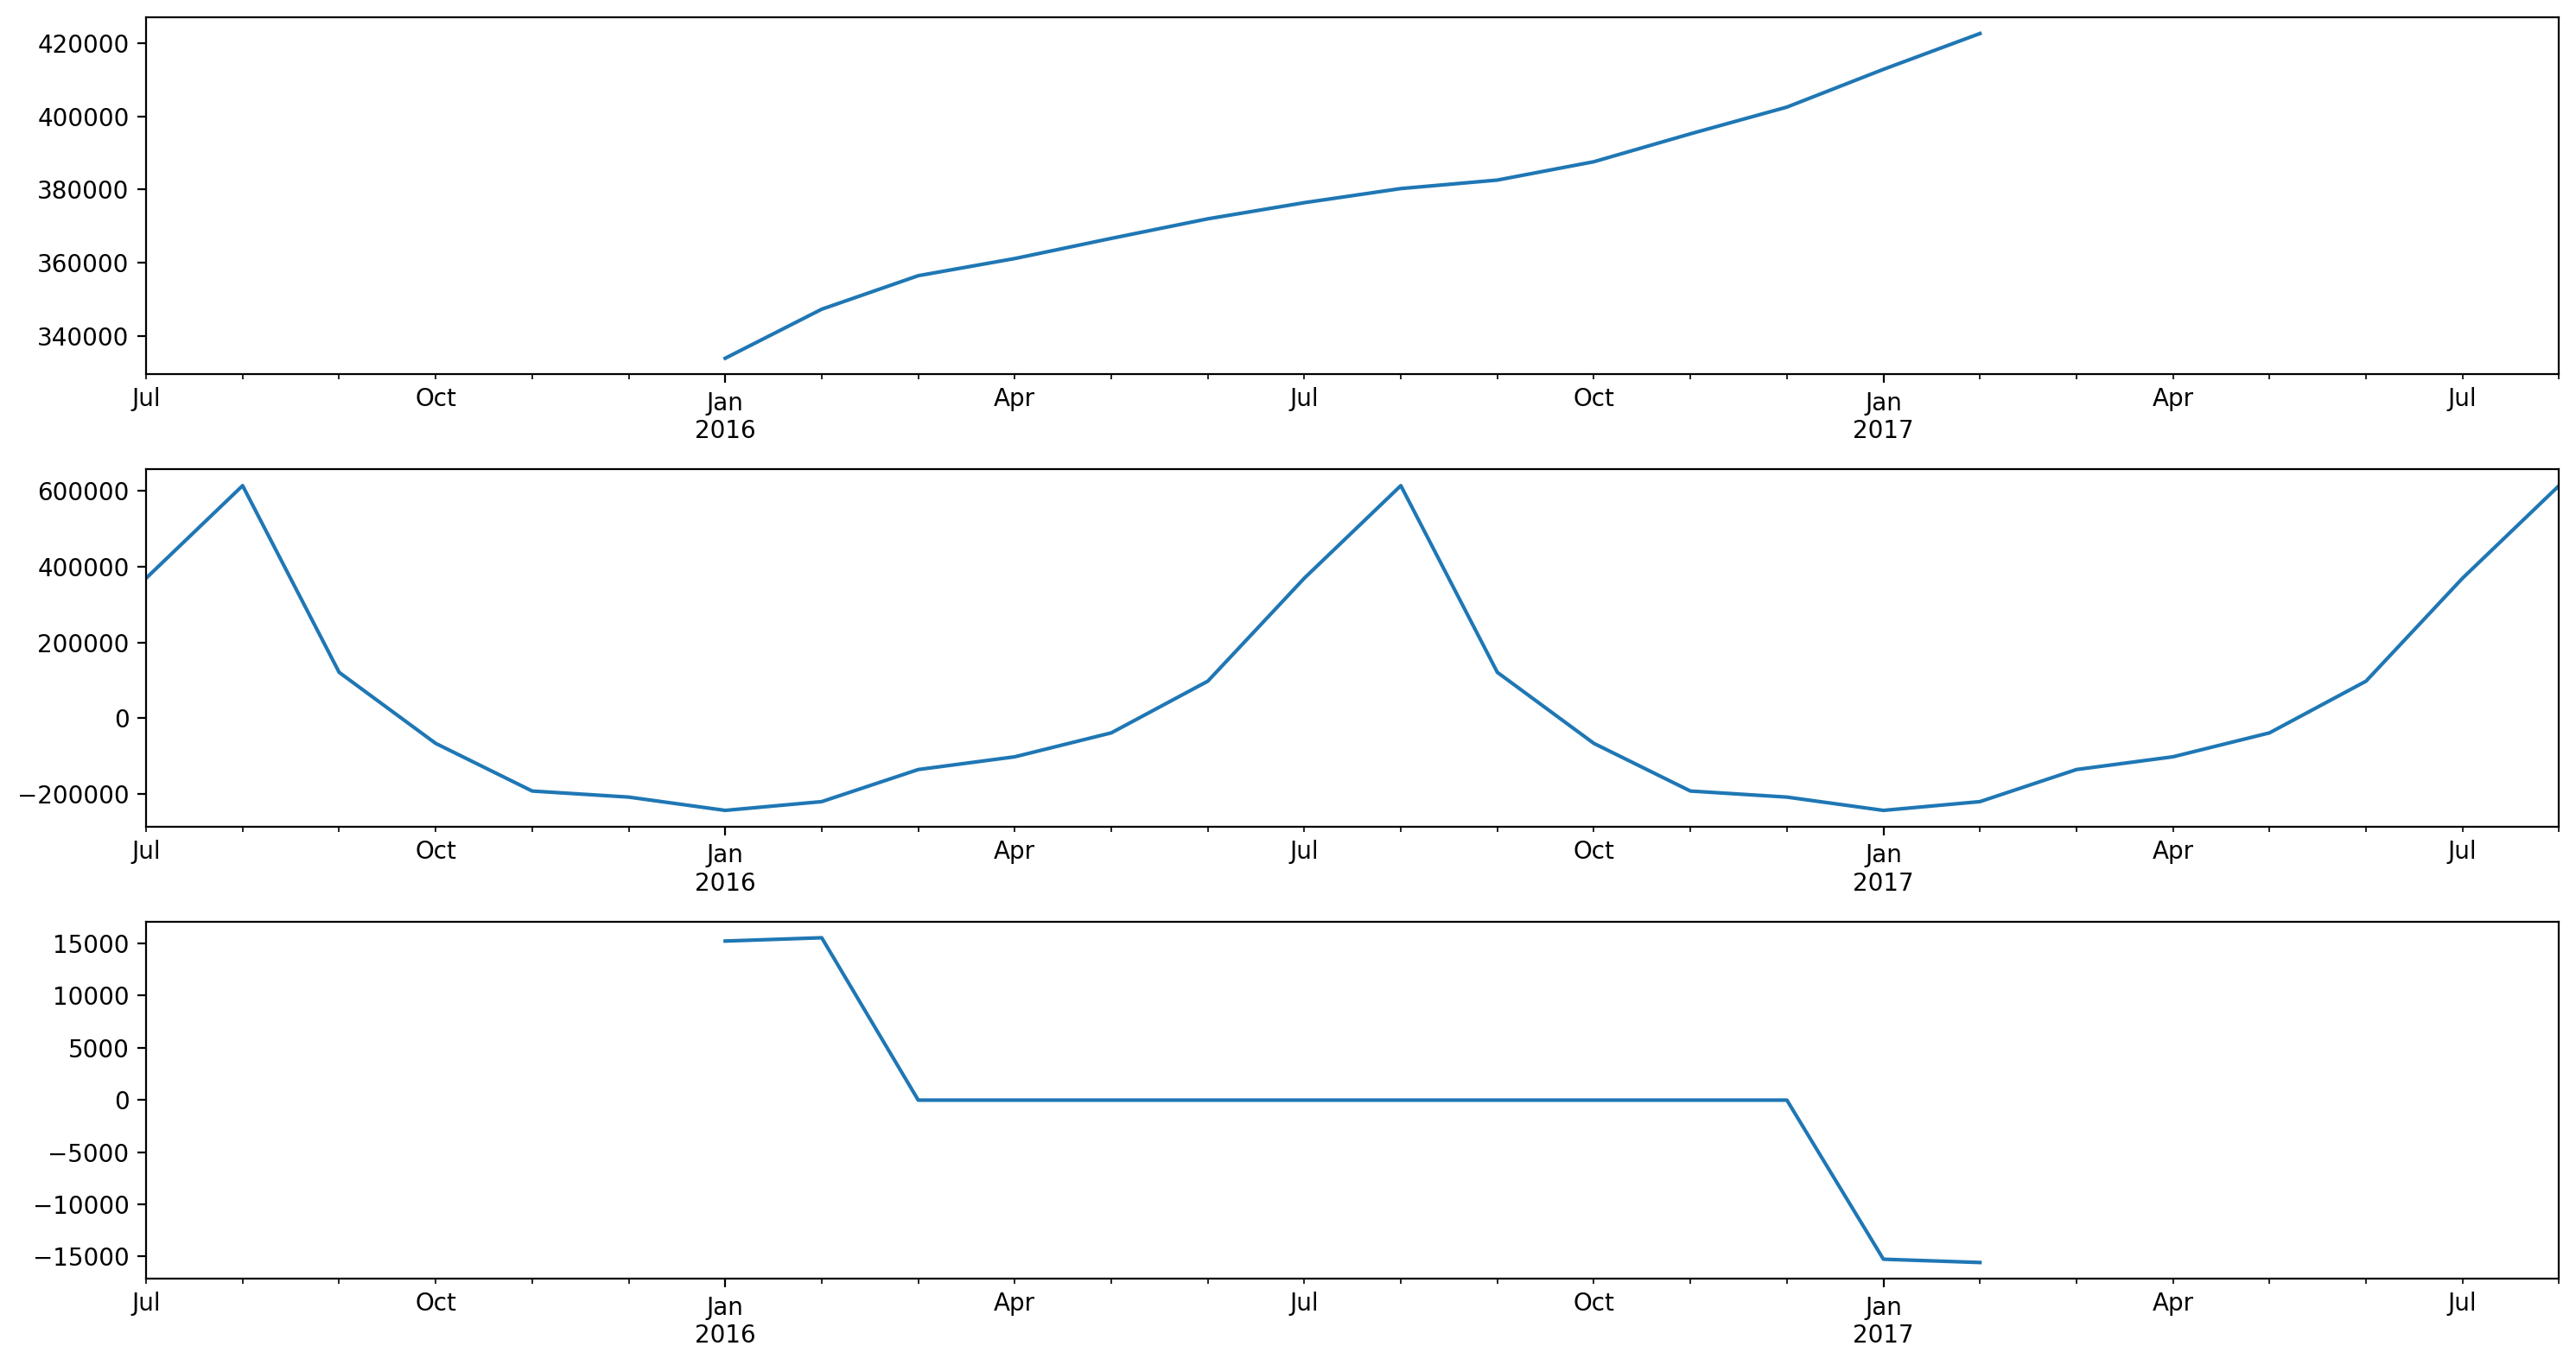

In [66]:
decomposed = seasonal_decompose(revenue_stream.drop('City Hotel', axis=1))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8), sharex=False)
decomposed.trend.plot(ax=ax1)
decomposed.seasonal.plot(ax=ax2)
decomposed.resid.plot(ax=ax3)
plt.tight_layout()
plt.show()